In [ ]:
!pip install -q transformers datasets scikit-learn accelerate

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
import torch.nn.functional as F
import shutil

In [ ]:
filename = "gramoty_train_fixed.csv"
df = pd.read_csv(filename)

In [ ]:
df.describe(include='all')

,text,century,city,year
count,988,989,989,989.000000
unique,985,10,13,NaN
top,-,XII_2,novgorod,NaN
freq,4,355,877,NaN
mean,NaN,NaN,NaN,1251.770475
std,NaN,NaN,NaN,101.493438
min,NaN,NaN,NaN,1037.000000
25%,NaN,NaN,NaN,1170.000000
50%,NaN,NaN,NaN,1210.000000
75%,NaN,NaN,NaN,1350.000000


In [ ]:
df['text'] = df['text'].astype(str).str.lstrip("`'")

In [ ]:
df = df[df['text'].apply(lambda x: isinstance(x, str) and len(x) > 5 and "#NAME" not in x)]

<Axes: >

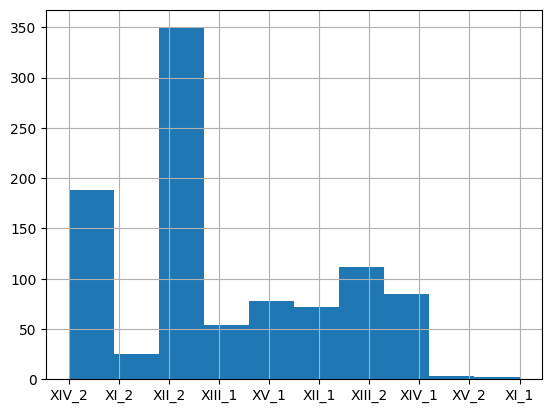

In [ ]:
df.century.hist()

<Axes: >

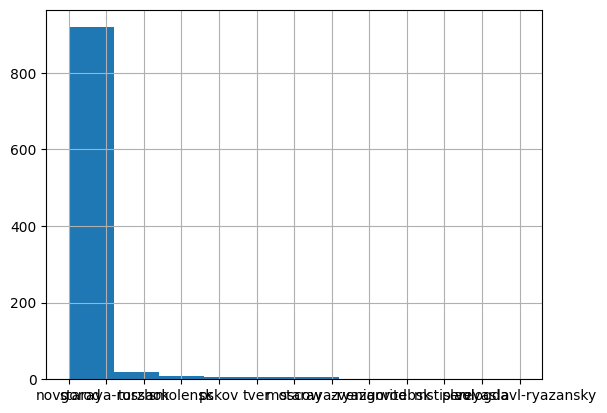

In [ ]:
df.city.hist()

In [ ]:
century_map = {
    # 11 век
    'XI_1': 'XI', 'XI_2': 'XI',
    # 12 век
    'XII_1': 'XII', 'XII_2': 'XII',
    # 13 век
    'XIII_1': 'XIII', 'XIII_2': 'XIII',
    # 14 век
    'XIV_1': 'XIV', 'XIV_2': 'XIV',
    # 15 век
    'XV_1': 'XV', 'XV_2': 'XV'
}

In [ ]:
df['target_label'] = df['century'].replace(century_map)

In [ ]:
print(df['target_label'].value_counts().sort_index())

target_label
XI       27
XII     422
XIII    166
XIV     273
XV       81
Name: count, dtype: int64


In [ ]:
# city_counts = df['city'].value_counts()
# valid_cities = city_counts[city_counts >= 15].index
# df = df[df['city'].isin(valid_cities)]
# df['target_label'] = df['city']

In [ ]:
labels = sorted(df['target_label'].unique())
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for i, l in enumerate(labels)}
df['labels'] = df['target_label'].map(label2id)

In [ ]:
train_df, val_df = train_test_split(
    df,
    test_size=0.15,
    stratify=df['target_label'],
    random_state=42
)

In [ ]:
train_dataset = Dataset.from_pandas(train_df[['text', 'labels']])
val_dataset = Dataset.from_pandas(val_df[['text', 'labels']])

In [ ]:
MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

In [ ]:
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/823 [00:00<?, ? examples/s]

Map:   0%|          | 0/146 [00:00<?, ? examples/s]

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./gramoty_bert_century",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=lambda p: {"accuracy": (np.argmax(p.predictions, axis=-1) == p.label_ids).mean()}
)

/tmp/ipython-input-4215759302.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.195408,0.527397
2,No log,0.997224,0.575342
3,No log,0.923634,0.623288
4,No log,0.961156,0.636986
5,No log,0.972534,0.602740


TrainOutput(global_step=260, training_loss=0.9571871830866887, metrics={'train_runtime': 210.4243, 'train_samples_per_second': 19.556, 'train_steps_per_second': 1.236, 'total_flos': 270682789059840.0, 'train_loss': 0.9571871830866887, 'epoch': 5.0})

In [ ]:
preds = np.argmax(trainer.predict(tokenized_val).predictions, axis=-1)
print(classification_report(tokenized_val['labels'], preds, target_names=labels, zero_division=0))

              precision    recall  f1-score   support

          XI       0.00      0.00      0.00         4
         XII       0.78      0.84      0.81        64
        XIII       0.50      0.28      0.36        25
         XIV       0.51      0.78      0.62        41
          XV       0.00      0.00      0.00        12

    accuracy                           0.64       146
   macro avg       0.36      0.38      0.36       146
weighted avg       0.57      0.64      0.59       146



In [ ]:
def predict_century(text):
    # 1. Готовим текст
    # Чистим так же, как при обучении
    clean_text = text.lstrip("`'").replace('\n', ' ')

    # 2. Превращаем в цифры
    inputs = tokenizer(clean_text, return_tensors="pt", truncation=True, max_length=128).to(model.device)

    # 3. Предсказываем
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # 4. Считаем вероятности (Softmax)
    probs = F.softmax(logits, dim=-1)[0]

    # 5. Ищем победителя
    top_prob, top_idx = torch.max(probs, dim=0)
    winner_label = id2label[top_idx.item()]

    # 6. Вывод
    print(f"\n📝 Текст: {clean_text[:100]}...")
    print(f"🏆 Вердикт: {winner_label} век (Уверенность: {top_prob.item():.1%})")

    # Показать топ-3 альтернативы
    print("Альтернативы:")
    # Сортируем вероятности
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    for i in range(1, min(4, len(labels))): # Показываем 3 следующих
        lbl = id2label[sorted_indices[i].item()]
        prob = sorted_probs[i].item()
        print(f"   - {lbl}: {prob:.1%}")

In [ ]:
text = "ѿ гостѧтꙑ къ васильви еже ми отьць даѧлъ и роди съдаѧли а то тобѣ ѿводь"
predict_century(text)


📝 Текст: ѿ гостѧтꙑ къ васильви еже ми отьць даѧлъ и роди съдаѧли а то тобѣ ѿводь...
🏆 Вердикт: XII век (Уверенность: 79.7%)
Альтернативы:
   - XIII: 11.3%
   - XIV: 4.3%
   - XI: 3.0%


In [ ]:
text = "поклоно ѿ трени к осподину ко ѳоме пришлѣте лошадкю и с проводнико"
predict_century(text)


📝 Текст: поклоно ѿ трени к осподину ко ѳоме пришлѣте лошадкю и с проводнико...
🏆 Вердикт: XIV век (Уверенность: 66.0%)
Альтернативы:
   - XV: 24.9%
   - XIII: 5.8%
   - XI: 2.3%


In [ ]:
text = "поклонъ ѿ ивана ко дмитрию клени сѧ ѧко възѧлъ еси оу мене вѣвериць"
predict_century(text)


📝 Текст: поклонъ ѿ ивана ко дмитрию клени сѧ ѧко възѧлъ еси оу мене вѣвериць...
🏆 Вердикт: XIV век (Уверенность: 66.2%)
Альтернативы:
   - XV: 26.0%
   - XIII: 4.7%
   - XI: 2.1%


In [ ]:
text = "покланѧние ѿ грикши къ ѥсифу"
inputs = tokenizer(text, return_tensors="pt", truncation=True).to(model.device)
print(f"\nТест: {text}")
print(f"Вердикт: {id2label[model(**inputs).logits.argmax().item()]}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Тест: покланѧние ѿ грикши къ ѥсифу
Вердикт: XII


In [ ]:
save_path = "best_model_centuries"

In [ ]:
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('best_model_centuries/tokenizer_config.json',
 'best_model_centuries/special_tokens_map.json',
 'best_model_centuries/vocab.txt',
 'best_model_centuries/added_tokens.json')

In [ ]:
shutil.make_archive("gramoty_model_v1", 'zip', save_path)

'/content/gramoty_model_v1.zip'